## Load data

In [51]:
import pandas as pd
import seaborn as sb
import sqlite3

import matplotlib.pyplot as plt

con = sqlite3.connect("../data/database_filtered.db")

track_df = pd.read_sql("SELECT * FROM Track", con=con)
artist_df = pd.read_sql(
    """
    SELECT artist.name as artist_name, genre.name as genre_name, * FROM artist_genre_through 
	JOIN artist on artist_genre_through.artist_id = artist.id 
	JOIN genre ON artist_genre_through.genre_id = genre.id
    """
    , con=con)
album_df = pd.read_sql("SELECT * FROM Album", con=con)

con.close()

track_df["duration_m"] = track_df["duration_ms"] / 60000  # Convert duration from miliseconds to minutes
track_df.dropna(inplace=True)

sb.set(rc={'figure.figsize': (14, 9)})

album_df["release_year"] = album_df["release_date"].apply(lambda x: x.split("-")[0])
album_df.head()

,id,uri,name,album_type,release_date,total_tracks,explicit,release_year
0,1,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook,album,2005-07-04,16,0,2005
1,2,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,In The Zone,album,2003-11-13,13,0,2003
2,3,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Dangerously In Love (Alben für die Ewigkeit),album,2003-06-23,16,0,2003
3,4,spotify:album:6QPkyl04rXwTGlGlcYaRoW,Justified,album,2002-11-04,13,0,2002
4,5,spotify:album:6NmFmPX56pcLBOFMhIiKvF,Hot Shot (International Version #2),album,2000,15,0,2000


# Charts

## Most frequent words in lyrics

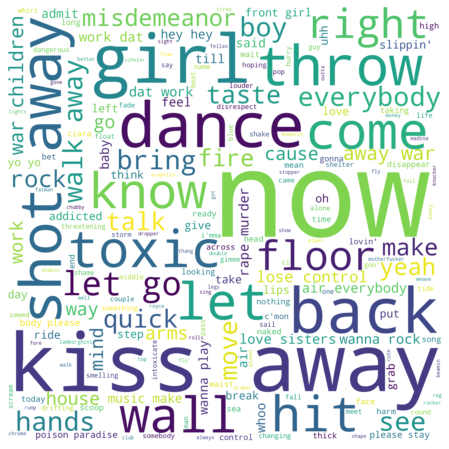

In [41]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure

figure(figsize=(30, 8))

lyrics_text = str(track_df["lyrics"].values).replace("\\n", " ").replace("\\'", "'").lower()
wordcloud = WordCloud(width=2000, height=2000, background_color="white").generate(lyrics_text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Albums over the years

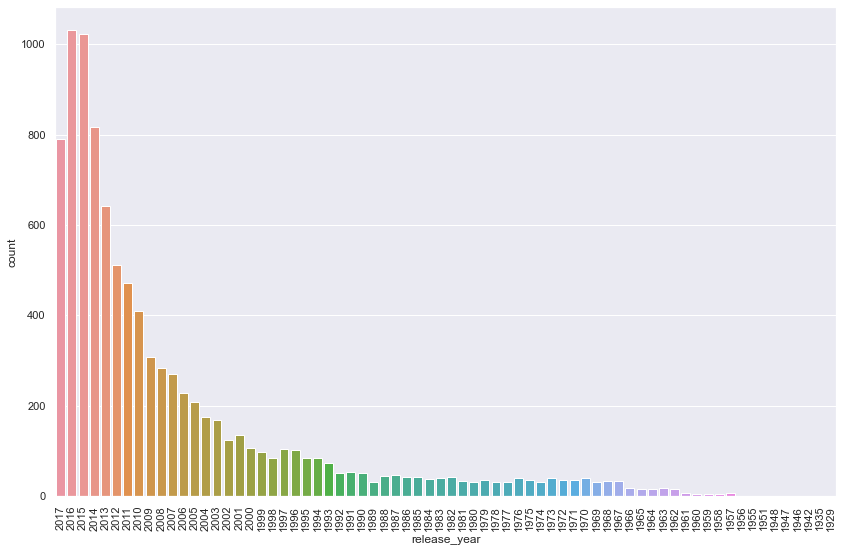

In [61]:
g = sb.countplot(x="release_year", data=album_df.sort_values(by="release_year", ascending=False));
g.set_xticklabels(g.get_xticklabels(), rotation=90);


## Most common genres

Plot top 50 common genres across artists

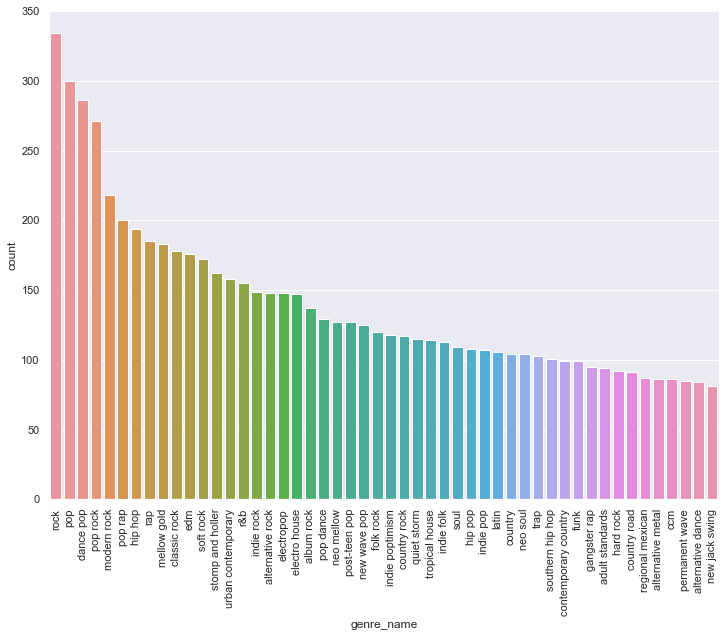

In [105]:
g = sb.countplot(x="genre_name", data=artist_df, order=artist_df["genre_name"].value_counts().iloc[:50].index)
g.set_xticklabels(g.get_xticklabels(), rotation=90);


# Track length

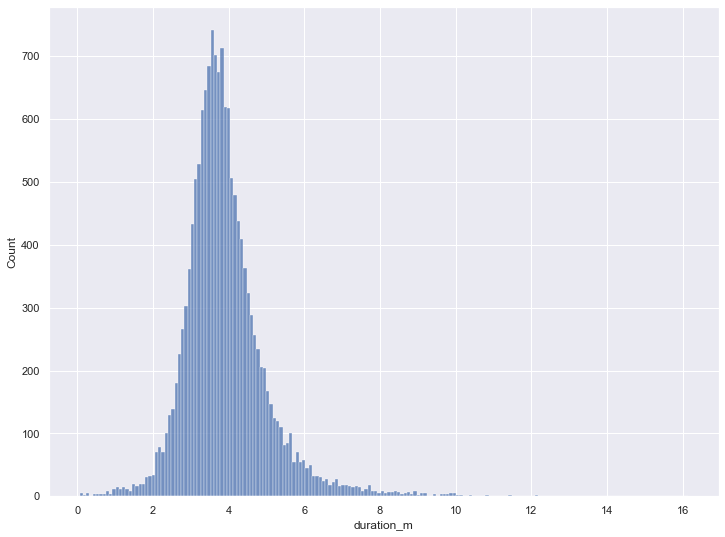

In [106]:
sb.histplot(data=track_df, x="duration_m");